In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from keras.layers import Bidirectional, GlobalMaxPool1D


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import re

print("Tensorflow Version",tf.__version__)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Tensorflow Version 2.4.0


In [2]:
df = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip',encoding = 'latin',
                 header=None)
df.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,0,1,2,3,4,5,6,7
0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
1,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
2,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
3,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
4,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0


In [3]:
df.columns = ["id", "comment_text","toxic","severe_toxic","obscene","threat","insult","identity_hate"]

In [4]:
df.drop(df.head(1).index,axis=0,inplace=True)

In [5]:
df.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [6]:
(df["threat"]==1).sum()

256

In [7]:
df["threat"]= np.where(df["identity_hate"]==1,1,df["threat"])

In [8]:
(df["threat"]==1).sum()

1039

In [9]:
df = df.drop(['id', 'severe_toxic', 'identity_hate',], axis=1)

In [10]:
df.head()

,comment_text,toxic,obscene,threat,insult
1,Explanation\nWhy the edits made under my usern...,0,0,0,0
2,D'aww! He matches this background colour I'm s...,0,0,0,0
3,"Hey man, I'm really not trying to edit war. It...",0,0,0,0
4,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0
5,"You, sir, are my hero. Any chance you remember...",0,0,0,0


In [11]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [12]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [13]:
df["comment_text"] = df["comment_text"].apply(lambda x: preprocess(x))

In [14]:
df.head()

,comment_text,toxic,obscene,threat,insult
1,explanation edits made username hardcore metal...,0,0,0,0
2,aww matches background colour seemingly stuck ...,0,0,0,0
3,hey man really trying edit war guy constantly ...,0,0,0,0
4,make real suggestions improvement wondered sec...,0,0,0,0
5,sir hero chance remember page,0,0,0,0


In [15]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [16]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))


Train Data size: 127656
Test Data size 31915


In [17]:
train_data.head(10)

,comment_text,toxic,obscene,threat,insult
73522,ad hominem mean name calling subhuman racist s...,1,0,0,0
122926,09 51 24 december 2011 utc,0,0,0,0
35414,editing style simplified example found referen...,0,0,0,0
131321,ah good schopenhauer place would go imagining ...,0,0,0,0
93896,nice class hi cite nice class concept frank pl...,0,0,0,0
39768,provide real sort justification using ukraine ...,0,0,0,0
7935,ok reordering give designations like calling l...,0,0,0,0
108684,nuking major edits per wikipedia copyright vio...,0,0,0,0
104716,currently interested principles involved radio...,0,0,0,0
119609,july 2007 utc yes found sources website appare...,0,0,0,0


In [18]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data["comment_text"])

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 151872


In [19]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data["comment_text"]),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data["comment_text"]),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (127656, 30)
Testing X Shape: (31915, 30)


In [20]:
x_train

array([[    0,     0,     0, ..., 24879,  1030, 17207],
       [    0,     0,     0, ...,   955,   952,    83],
       [    0,     0,     0, ...,    84,  5866,   620],
       ...,
       [    0,     0,     0, ...,  3309,   433,   794],
       [    0,     0,     0, ...,    42,    43,  7810],
       [    0,     0,     0, ...,   740,   477,  2204]], dtype=int32)

In [21]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove.6B.zip

In [22]:
list_classes = ["toxic", "obscene", "threat", "insult"]
y_train = train_data[list_classes].values.astype(int)
y_test = test_data[list_classes].values.astype(int)

In [23]:
GLOVE_EMB = '../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = '.../output/kaggle/working/best_model.hdf5'

In [24]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(GLOVE_EMB))

In [25]:
max_features = 200000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100

In [26]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [27]:
#embeddings_index = {}

#f = open(GLOVE_EMB)
#for line in f:
 # values = line.split()
  #word = value = values[0]
  #coefs = np.asarray(values[1:], dtype='float32')
  #embeddings_index[word] = coefs
#f.close()

#print('Found %s word vectors.' %len(embeddings_index))

In [28]:
#embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
#for word, i in word_index.items():
#  embedding_vector = embeddings_index.get(word)
##  if embedding_vector is not None:
  #  embedding_matrix[i] = embedding_vector

In [29]:
embedding_layer = tf.keras.layers.Embedding(nb_words,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

In [30]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [31]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(300, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
outputs = Dense(4, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)


In [32]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping, ModelCheckpoint
my_callbacks = [EarlyStopping(monitor = 'val_loss', 
                              min_delta = 0.001,
                              patience = 3, 
                              mode = 'min', 
                              verbose = 1,
                              restore_best_weights = True),
                ModelCheckpoint(filepath='model.h5', 
                                save_best_only = True, 
                                monitor = 'val_loss', 
                                mode = 'min', verbose = 1),
                ReduceLROnPlateau(monitor='val_loss',
                                  factor=0.1,
                                  patience=2, 
                                  min_lr=0.00001,
                                  mode='min',
                                  verbose=1)]
model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])



In [33]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [34]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Training on GPU...


In [35]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=my_callbacks)

Epoch 1/10
125/125 [==============================] - 48s 307ms/step - loss: 0.2094 - accuracy: 0.7873 - val_loss: 0.0909 - val_accuracy: 0.9941

Epoch 00001: val_loss improved from inf to 0.09093, saving model to model.h5
Epoch 2/10
125/125 [==============================] - 37s 296ms/step - loss: 0.0840 - accuracy: 0.9324 - val_loss: 0.0775 - val_accuracy: 0.9941

Epoch 00002: val_loss improved from 0.09093 to 0.07752, saving model to model.h5
Epoch 3/10
125/125 [==============================] - 38s 303ms/step - loss: 0.0741 - accuracy: 0.9409 - val_loss: 0.0720 - val_accuracy: 0.9901

Epoch 00003: val_loss improved from 0.07752 to 0.07198, saving model to model.h5
Epoch 4/10
125/125 [==============================] - 36s 290ms/step - loss: 0.0686 - accuracy: 0.9555 - val_loss: 0.0725 - val_accuracy: 0.9939

Epoch 00004: val_loss did not improve from 0.07198
Epoch 5/10
125/125 [==============================] - 37s 299ms/step - loss: 0.0668 - accuracy: 0.9725 - val_loss: 0.0720 - va

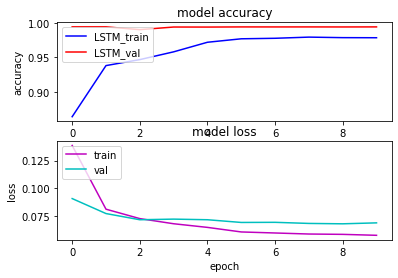

In [36]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [37]:
scores = model.predict(x_test, verbose=1, batch_size=10000)

4/4 [==============================] - 2s 230ms/step


In [38]:
scores

array([[3.8366260e-03, 3.3015272e-04, 5.4262920e-05, 4.3153524e-04],
       [2.7468042e-03, 1.4818806e-04, 2.7605816e-05, 2.4631410e-04],
       [4.1988371e-03, 5.6843582e-04, 6.7667381e-05, 5.4470112e-04],
       ...,
       [9.6098790e-03, 1.0462592e-03, 2.6697782e-04, 1.5223882e-03],
       [1.2869659e-03, 1.1653811e-04, 1.3014995e-05, 1.3302341e-04],
       [4.2824659e-02, 5.4855193e-03, 1.4249532e-03, 5.6153326e-03]],
      dtype=float32)

In [39]:
list(y_test)

[array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([1, 1, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([1, 1, 0, 1]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([1, 1, 0, 1]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([1, 1, 0, 1]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0, 0, 0, 0]),
 array([0,

In [40]:
def decode_sentiment(score):
    result= []
    if score[0]>0.5:
        result.append("Toxic")
    else:
        result.append("-")
    if score[1]>0.5:
        result.append("Obscene")
    else:
        result.append("-")
    if score[2]>0.5:
        result.append("Threat")
    else:
        result.append("-")
    if score[3]>0.5:
        result.append("Insult")
    else:
        result.append("-")
    return result

scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]


4/4 [==============================] - 1s 226ms/step


In [41]:
y_pred_1d

[['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['Toxic', 'Obscene', '-', 'Insult'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['Toxic', 'Obscene', '-', 'Insult'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['Toxic', 'Obscene', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['Toxic', 'Obscene', '-', 'Insult'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 [

In [42]:
jigsaw_text=pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/test.csv.zip")

In [43]:
jigsaw_text.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [44]:
test=jigsaw_text["comment_text"]

In [45]:
test= preprocess(test)

In [46]:
test = pad_sequences(tokenizer.texts_to_sequences(list(test)),
                       maxlen = MAX_SEQUENCE_LENGTH)

In [47]:
test

array([[  0,   0,   0, ...,   0,   0, 407],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0, 180],
       [  0,   0,   0, ...,   0,   0, 251],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=int32)

In [48]:
pred1=model.predict(test)

In [49]:
y_pred_final = [decode_sentiment(pred) for pred in pred1]

In [50]:
y_pred_final

[['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['Toxic', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['Toxic', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['-', '-', '-', '-'],
 ['

In [51]:
csv1= pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip")

In [52]:
csv1

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,-1,-1,-1,-1,-1,-1
153160,fffd7a9a6eb32c16,-1,-1,-1,-1,-1,-1
153161,fffda9e8d6fafa9e,-1,-1,-1,-1,-1,-1
153162,fffe8f1340a79fc2,-1,-1,-1,-1,-1,-1
